In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
#get a connection
con = sqlite3.connect('database.sqlite') 

In [3]:
#limit data to 5k

data_5000 = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

In [4]:
#prepare data

def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = data_5000['Score']
positiveNegative = actualScore.map(partition) 
data_5000['Score'] = positiveNegative
print("Number of data points in our data", data_5000.shape)
data_5000.head(10)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [5]:
sorted_5k=data_5000.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='mergesort', na_position='last')


In [6]:
print(sorted_5k.head())

        Id   ProductId          UserId                  ProfileName  \
2546  2774  B00002NCJC  A196AJHU9EASJN                 Alex Chaffee   
2547  2775  B00002NCJC  A13RRPGE79XFFH                     reader48   
1145  1244  B00002Z754  A3B8RCEI0FXFI6                    B G Chase   
1146  1245  B00002Z754  A29Z5PI9BW2PU3                       Robbie   
2941  3203  B000084DVR  A3DKGXWUEP1AI2  Glenna E. Bauer "Puppy Mum"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2546                     0                       0      1  1282953600   
2547                     0                       0      1  1281052800   
1145                    10                      10      1   962236800   
1146                     7                       7      1   961718400   
2941                     3                       3      1  1163030400   

                             Summary  \
2546                   thirty bucks?   
2547                    Flies Begone   
1145  WOW Make

In [7]:
final=sorted_5k.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [8]:
final['Text'].head()

2546    Why is this $[...] when the same product is av...
2547    We have used the Victor fly bait for 3 seasons...
1145    I just received my shipment and could hardly w...
1146    This was a really good idea and the final prod...
2941    We have been using this food for about 6 month...
Name: Text, dtype: object

In [9]:
def decontracted(phrase):

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
previews=[]
for text in final['Text'].values:
    text=re.sub(r'http\S+','',text)
    text = BeautifulSoup(text,'lxml').get_text()
    text = decontracted(text)
    text = re.sub("\S*\d\S*", "", text).strip()
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords)
    previews.append(text.strip())
    

In [11]:
#BoW
cv = CountVectorizer(min_df=10) 


cv.fit(previews)
print("Features/Unique words ", cv.get_feature_names()[:10])
print('='*50)

bowfinal = cv.transform(previews)

print("the type of count vectorizer ",type(bowfinal))
print("the shape of out text BOW vectorizer ",bowfinal.get_shape())
print("the number of unique words ", bowfinal.get_shape()[1])

Features/Unique words  ['ability', 'able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'acidity', 'across', 'active']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 2218)
the number of unique words  2218


In [12]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity= 20, n_iter= 3000)

data=bowfinal[:4000]

print(data.shape)
tsne_data_dense=data.todense()
print(tsne_data_dense.shape)

(4000, 2218)
(4000, 2218)


(4000, 2)


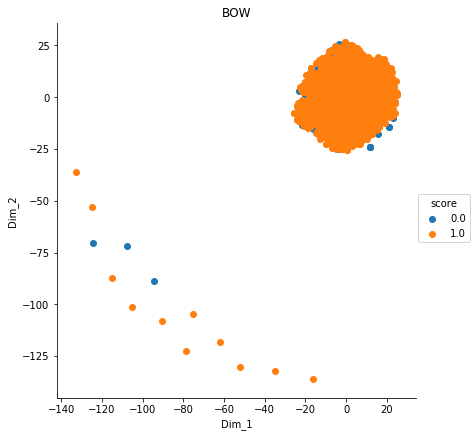

In [26]:


tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']




tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("BOW")
plt.show()

## Observation:
1. Since BOW involves words as features and every feature is likely to be part of both positive and negative reviews, it is not distinguishable between positive and negative reviews
2. Although we can see some reviews to be away from the cluster which might signify they are outliers or less likely to be very unique reviews.
3. There are often very less number of words which appear uniquely either only in positive or negative reviews, which is dominated by other more commonly used words.


In [13]:
tifinal = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_df=1000)

tifinal.fit(previews)

ti_final = tifinal.transform(previews)

(4000, 2)


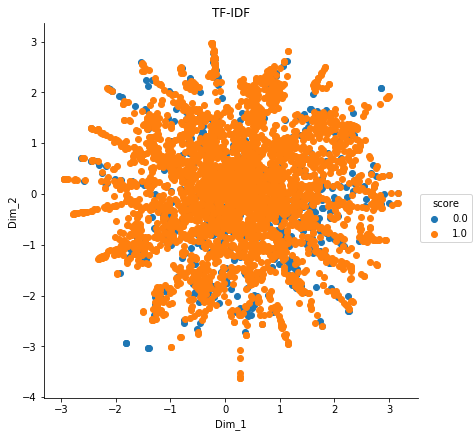

In [27]:
model = TSNE(n_components=2, random_state=0, perplexity= 20, n_iter= 3000)

data=ti_final[:4000]


tsne_data_dense=data.todense()

tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TF-IDF")
plt.show()

## Observation:
1. Unlike BOW model, where both positive and negative reviews overlapped,atleast some of positive and negative reviews of TF-IDF model are not overlapping.
2. However, this is not very useful.

In [28]:
len(previews)

4986

In [14]:
# avg w2v


i=0
list_of_sentance=[]
for sentance in previews:
    list_of_sentance.append(sentance.split())


w2v_model=Word2Vec(list_of_sentance,min_count=10,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

sent_vectors = []; 
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

print(sent_vectors[2])

  2%|▏         | 97/4986 [00:00<00:05, 949.04it/s]

[('snack', 0.9936407208442688), ('alternative', 0.9918918013572693), ('tasty', 0.9908749461174011), ('wonderful', 0.9906941652297974), ('regular', 0.9904305338859558), ('baked', 0.9903949499130249), ('licorice', 0.9899244904518127), ('satisfying', 0.9899089336395264), ('amazing', 0.9898557662963867), ('absolutely', 0.9898353815078735)]
[('varieties', 0.999363362789154), ('summer', 0.9992789626121521), ('pods', 0.999231219291687), ('oh', 0.999184250831604), ('gourmet', 0.9991595149040222), ('outstanding', 0.9991559982299805), ('type', 0.9991230368614197), ('chocolates', 0.9991005659103394), ('lover', 0.9990852475166321), ('european', 0.9990842938423157)]
number of words that occured minimum 5 times  2417
sample words  ['product', 'available', 'course', 'total', 'pretty', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'easily', 'daughter', 'designed', 'use', 'car', 'windows', 'shop', 'program',

100%|██████████| 4986/4986 [00:04<00:00, 1037.44it/s]

4986
[ 0.2575783   0.05613533  0.07373576  0.31283998 -0.23747336 -0.25969768
 -0.09140524 -0.07073041 -0.15563948  0.30799187 -0.11037367 -0.43580284
 -0.53467749 -0.42163295 -0.44858493  0.07204781 -0.07629652 -0.41733788
  0.14068294  0.16824278 -0.94940512 -0.13449739 -0.22246655 -0.12111806
  0.26447396 -0.02149871 -0.47737226  0.00271484 -0.23771825  0.29612017
  0.31352966  0.31915493  0.07254008  0.42875399 -0.18663441  0.26319163
  0.01284388  0.02327078 -0.08157789  0.12420926  0.02961578  0.12440528
 -0.68976505  0.04790076 -0.07366794  0.3635181   0.02109268 -0.20028036
 -0.34421317  0.10393799]


(4000, 2)


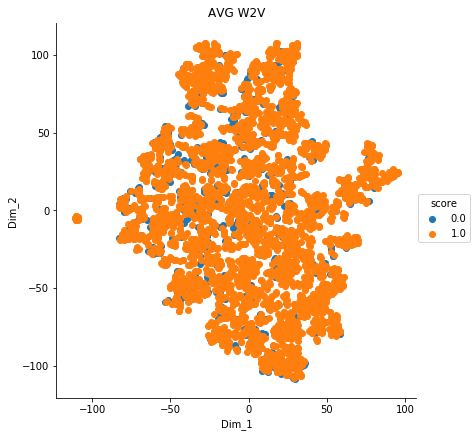

In [30]:
#Avg w2v

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity= 20, n_iter= 3000)

sent_vectors=np.asmatrix(sent_vectors)

tsne_data_dense=sent_vectors[:4000]

tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']

tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("AVG W2V")
plt.show()

## Observations:

1. Apparently most of the positive and negative reviews are overlapping
2. And the cluster is spread over the vertical axis than horizontally


(4000, 2)


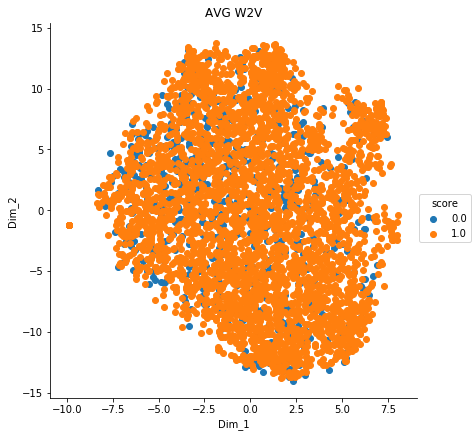

In [17]:
#Different perplexity for Avg W2V

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity= 500, n_iter= 3000)

sent_vectors=np.asmatrix(sent_vectors)

tsne_data_dense=sent_vectors[:4000]

tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']

tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("AVG W2V")
plt.show()

## Observations:

1. Well the perplexity change from 20 to 100 didn't seem to change the shape but spread of the data widened with perplexity 500.
2. The range of data spread changed from -100 to 100 (low perplexity) to -10 to 10(high perplexity)

In [32]:
# TFIDF weighted W2V

model = TfidfVectorizer()
model.fit(previews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
print(len(dictionary))

12997


In [33]:
# TFIDF weighted W2V

tfidf_feat = model.get_feature_names() 

tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:25<00:00, 193.52it/s]


(4000, 2)


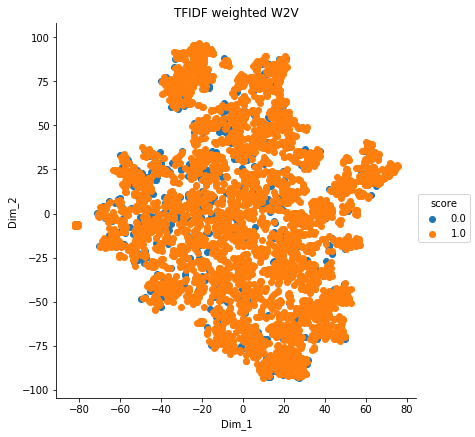

In [34]:
# TFIDF weighted W2V

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity= 20, n_iter= 3000)

tfidf_sent_vectors=np.asmatrix(sent_vectors)

tsne_data_dense=tfidf_sent_vectors[:4000]

tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']

tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TFIDF weighted W2V")
plt.show()

## Observations
1. Positive & negative review overlap is less in TFIDF - W2V compared to other methods
2. Same is the case for TF-IDF.

(4000, 2)


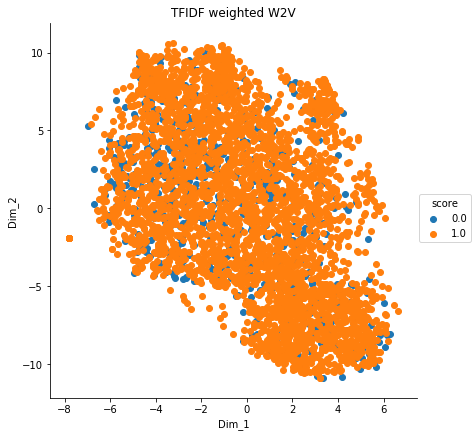

In [19]:
# TFIDF weighted W2V

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity= 700, n_iter= 3000)

tfidf_sent_vectors=np.asmatrix(sent_vectors)

tsne_data_dense=tfidf_sent_vectors[:4000]

tsne_data = model.fit_transform(tsne_data_dense)

print(tsne_data.shape)

labels_1000=final['Score']

tsne_data = np.vstack((tsne_data.T, labels_1000[:4000])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2",'score'))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TFIDF weighted W2V")
plt.show()